## Fastmarch ORCA Policy

In [1]:
import numpy as np
from crowd_sim.envs.policy.orca import ORCA
from crowd_sim.envs.utils.state import JointState
import CMap2D
import matplotlib.pyplot as plt
from map2d import gridshow

class Suicide(object):
    def __init__(self):
        pass

class FastmarchORCAPolicy(object):
    def __init__(self, suicide_if_stuck=False):
        self.simulator = ORCA()
        self.suicide_if_stuck = suicide_if_stuck
        self.map = CMap2D.CMap2D()
        self.grid_num = 100
        self.new = True

    def reset(self):
        self.new = True
        self.simulator.reset()        
    
    def predict(self, obs, env):
        self.simulator.time_step = env._get_dt()
        other_agent_states = [
            agent.get_observable_state() for agent in env.soadrl_sim.humans + env.soadrl_sim.other_robots]
        joint_state = JointState(env.soadrl_sim.robot.get_full_state(), other_agent_states)
        
        if self.new:
            #find an appropriate origin
            bbox = env.soadrl_sim.obstacle_vertices[-1]
            bbox_ll = np.array(bbox[-1])
            bbox_tr = np.array(bbox[1])
            self.map.origin[0] = bbox_ll[0] - 0.25
            self.map.origin[1] = bbox_ll[1] - 0.25
            
            #find the right resolution
            max_dim = max(bbox_tr-bbox_ll)
            #offset = 2*max_dim/self.grid_num
            self.map.set_resolution((max_dim+2*0.25)/self.grid_num)
            
            #initialise occupancy
            self.map._occupancy = np.ones((self.grid_num,self.grid_num), dtype = np.float32)
            bbox_ij = self.map.xy_to_ij(bbox)
            self.map._occupancy[bbox_ij[-1,0]:bbox_ij[1,0], bbox_ij[-1,1]:bbox_ij[1,1]] = 0
            
            radius = env.soadrl_sim.robot.radius*1.05
            for vertex in env.soadrl_sim.obstacle_vertices[:-1]:
                xy_min, xy_max = np.min(vertex, 0), np.max(vertex,0)
                xy_min -= radius
                xy_max += radius
                min_max_ij = self.map.xy_to_ij([xy_min,xy_max])
                self.map._occupancy[min_max_ij[0,0]:min_max_ij[1,0], min_max_ij[0,1]:min_max_ij[1,1]] = 1
            #self.map.HUGE_ = 100 * np.prod( self.map._occupancy.shape )
            #calculate the field
            goal = self.map.xy_to_ij([(env.soadrl_sim.robot.gx,env.soadrl_sim.robot.gy)])
            self.field = self.map.fastmarch(goal[0])
            
            plt.figure("occupancy", figsize=[8,8]) 
            grid = self.map.occupancy()
            gridshow(self.field)
            
            self.new = False
        
            # only for vizualisation atm
            robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
            robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
            gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8)
            plt.plot(gridfmpath8[:,0],  gridfmpath8[:,1] , '-o', color=plt.cm.winter(0.33) , mec=plt.cm.winter(0.33), mfc=[0,0,0,0])
            plt.show()
        robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
        robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
        gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8) 
        
        if gridfmpath8.shape[0] > 15:
            virtual_goal = gridfmpath8[15]  # look forward in path
            virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
            virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
            print("vx: ", joint_state.self_state.vx,"vy: ", joint_state.self_state.vy, "v: ",
                  np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2))
            joint_state.self_state.gx = virtual_goal[0]
            joint_state.self_state.gy = virtual_goal[1]
            
            if np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2) < 0.25:
                virtual_goal = gridfmpath8[8]  # look forward in path
                virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
                virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
                idx = np.argmin([virtual_goal[0] - robot_pos_xy[0],virtual_goal[0] - robot_pos_xy[0]])
                print("idx: ", idx)
                if idx == 0:
                    joint_state.self_state.gx = robot_pos_xy[0] + np.sign(virtual_goal[0] - robot_pos_xy[0])#*(virtual_goal[1] - robot_pos_xy[1]) #virtual_goal[0]
                elif idx == 1:
                    joint_state.self_state.gy = robot_pos_xy[1] + np.sign(virtual_goal[1] - robot_pos_xy[1])#*(virtual_goal[0] - robot_pos_xy[0]) #virtual_goal[1]
            
        action = self.simulator.predict(
            joint_state,
            env.soadrl_sim.obstacle_vertices,
            env.soadrl_sim.robot,
        )
        if self.suicide_if_stuck:
            if action.v < 0.02:
                return Suicide()
        vx = action.v * np.cos(action.r)
        vy = action.v * np.sin(action.r)
        return np.array([vx, vy]) #, 0.1*(np.random.random()-0.5)

/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib

## Play Policy

In [2]:
import os

def play_policy(env, n_sequences, episode_length=1000,
                         subset_index=0, n_subsets=1,
                         render=True,
                         policy=FastmarchORCAPolicy(),
                         archive_dir=os.path.expanduser("~/navrep/datasets/V/ian")
                         ):
    """
    if n_subsets is None, the whole set of sequences is generated (n_sequences)
    if n_subsets is a number > 1, this function only generates a portion of the sequences
    """
    indices = np.arange(n_sequences)
    if n_subsets > 1:  # when multiprocessing
        indices = np.array_split(indices, n_subsets)[subset_index]
    scans = []
    robotstates = []
    actions = []
    rewards = []
    dones = []
    for n in indices:
        policy.reset()
        obs = env.reset()
        for i in range(episode_length):
            # step
            action = policy.predict(obs, env)
            if isinstance(action, Suicide):
                obs = env.reset()
                rew = 0
                action = np.array([0, 0, 0])
                done = True
            else:
                obs, rew, done, _ = env.step(action)
            scans.append(obs[0])
            robotstates.append(obs[1])
            actions.append(action)
            rewards.append(rew)
            dones.append(done)
            if render:
                env.render(save_to_file=False)
            if done:
                policy.reset()
                obs = env.reset()
        dones[-1] = True

    scans = np.array(scans)
    robotstates = np.array(robotstates)
    actions = np.array(actions)
    rewards = np.array(rewards)
    dones = np.array(dones)
    data = dict(scans=scans, robotstates=robotstates, actions=actions, rewards=rewards, dones=dones)
        #if archive_dir is not None:
         #   make_dir_if_not_exists(archive_dir)
          #  archive_path = os.path.join(
           #     archive_dir, "{:03}_scans_robotstates_actions_rewards_dones.npz".format(n)
            #)
            #np.savez_compressed(archive_path, **data)
            #print(archive_path, "written.")
    env.close()
    return data

Ros was not found, disabled.


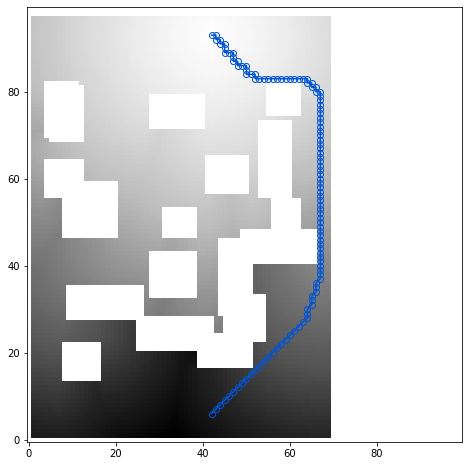

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.12679137289524084 vy:  0.3905969858169555 v:  0.4106605137701346
vx:  0.6043119430541992 vy:  0.4377758502960205 v:  0.746217541753305
vx:  0.6411378383636477 vy:  0.7458273768424987 v:  0.9835223453635273
vx:  0.6067259311676025 vy:  0.7947654724121094 v:  0.9998842491456887
vx:  0.6067194342613218 vy:  0.794757127761841 v:  0.9998736740401908
vx:  0.6067118644714353 vy:  0.7947471141815187 v:  0.9998611213514891
vx:  0.6067031621932985 vy:  0.7947359085083009 v:  0.9998469339293201
vx:  0.6066932678222657 vy:  0.7947224378585815 v:  0.9998302228162271
vx:  0.5996788740158083 vy:  0.785534381866455 v:  0.9882707205190191
vx:  0.5990031361579895 vy:  0.7846491932868959 v:  0.9871570866143258
vx:  0.6270830035209655 vy:  0.7789524197578432 v:  0.9999999827757371
vx:  0.6270830035209655 vy:  0.7789524197578432 v:  0.9999999827757371
vx:  0.6270830035209655 vy:  0.7789524197578432 v:  0.9999999827757371
vx:  0.6270830035209655 vy:  0.7789524197578

vx:  -0.0647836923599244 vy:  0.22613139450550074 v:  0.2352282601576344
idx:  0
vx:  -0.06219239532947542 vy:  0.21708618104457855 v:  0.22581918438728205
idx:  0
vx:  -0.059704661369323744 vy:  0.20840267837047577 v:  0.21678635321720227
idx:  0
vx:  -0.057316467165947 vy:  0.20006661117076874 v:  0.2081149353452093
idx:  0
vx:  -0.055023759603500436 vy:  0.19206394255161283 v:  0.1997903204596585
idx:  0
vx:  -0.05282285809516906 vy:  0.18438135087490082 v:  0.1917986884412812
idx:  0
vx:  -0.05070994794368744 vy:  0.17700609564781192 v:  0.1841267409067293
idx:  0
vx:  -0.04868160188198092 vy:  0.16992583870887756 v:  0.1767616729461202
idx:  0
vx:  -0.046734243631362915 vy:  0.1631288081407547 v:  0.1696911829566249
idx:  0
vx:  -0.0448649376630783 vy:  0.15660366415977478 v:  0.16290356122497576
idx:  0
vx:  -0.04307028651237491 vy:  0.15033955872058866 v:  0.15638744353866582
idx:  0
vx:  -0.0413475334644318 vy:  0.14432597160339355 v:  0.15013195730042245
idx:  0
vx:  -0.039693

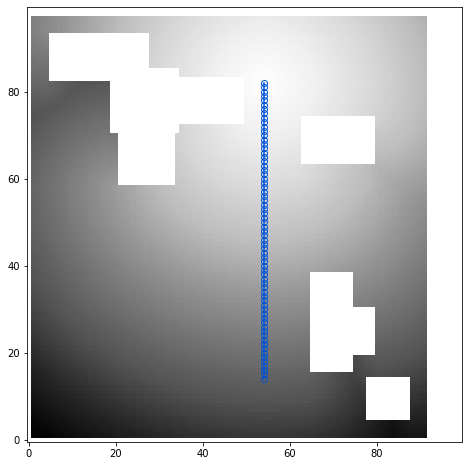

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.04657186567783349 vy:  0.3650759160518647 v:  0.3680344591934596
vx:  -0.11536224186420438 vy:  0.5822330713272095 v:  0.5935518479417368
vx:  0.011858731508254963 vy:  0.5065023899078369 v:  0.5066411950239886
vx:  0.004993121605366566 vy:  0.47825565934181213 v:  0.4782817234181518
vx:  0.012919463217258453 vy:  0.5511564612388611 v:  0.5513078607231773
vx:  0.04445397853851299 vy:  0.6281375885009767 v:  0.6297086519142999
vx:  0.0686893016099931 vy:  0.6815602779388428 v:  0.6850128704044481
vx:  0.07605576515197775 vy:  0.7124569416046143 v:  0.716504970710918
vx:  0.08124895393848418 vy:  0.7310264706611634 v:  0.735527765161462
vx:  0.08522738516330716 vy:  0.742971658706665 v:  0.7478439628847102
vx:  0.08856943994760495 vy:  0.7514187097549438 v:  0.7566205277828622
vx:  0.09164255112409568 vy:  0.758122980594635 v:  0.7636418079716601
vx:  0.09470761567354213 vy:  0.7641258835792542 v:  0.7699726608278655
vx:  0.0979982241988184 vy: 

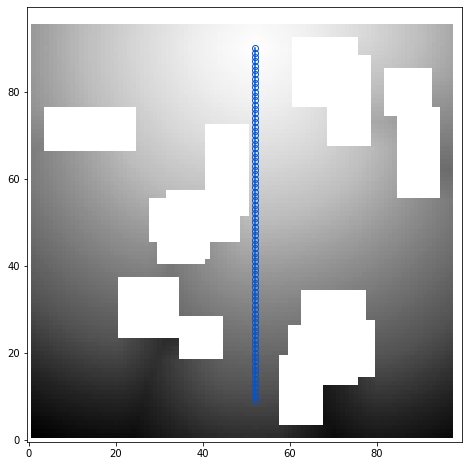

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.19792297482490545 vy:  0.49299412965774536 v:  0.5312407324749656
vx:  0.007225781679153387 vy:  0.8254342675209044 v:  0.8254658938554922
vx:  -0.011396866291761232 vy:  0.8515191078186035 v:  0.8515953731329585
vx:  -0.011396866291761232 vy:  0.8515191078186035 v:  0.8515953731329585
vx:  -0.011396866291761232 vy:  0.8515191078186035 v:  0.8515953731329585
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.005872568581253346 vy:  0.8515750765800476 v:  0.8515953253242149
vx:  -0.005872568581253346 vy:  0.8515750765800476 v:  0.8515953253242149
vx:  -

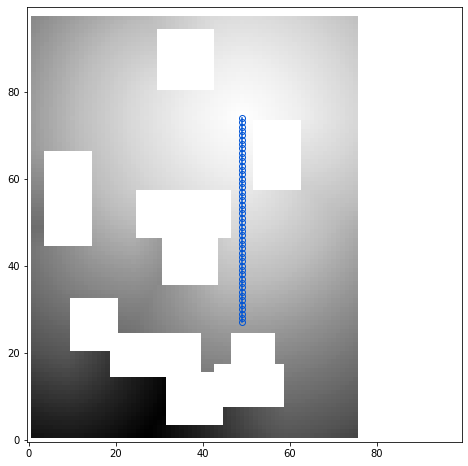

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.05777229368686675 vy:  -0.02265865541994572 v:  0.062056849608092574
idx:  0
vx:  -0.025974990800023086 vy:  0.07161587476730347 v:  0.07618092717831267
idx:  0
vx:  -0.0012397072277962745 vy:  0.14137159287929535 v:  0.1413770283576504
idx:  0
vx:  0.16508938372135157 vy:  0.17345561087131503 v:  0.23946054698057617
idx:  0
vx:  0.20075237751007077 vy:  0.21391485631465906 v:  0.2933616928436077
vx:  0.21395026147365567 vy:  0.24128210544586182 v:  0.3224775477347743
vx:  0.22369939088821414 vy:  0.25812646746635437 v:  0.3415709160488008
vx:  0.22878697514533997 vy:  0.268747478723526 v:  0.35294289526268474
vx:  0.22971032559871674 vy:  0.27576717734336853 v:  0.3589071882626445
vx:  0.22690877318382263 vy:  0.2809652090072632 v:  0.36114960891614234
vx:  0.21821279823780065 vy:  0.2867177724838257 v:  0.3603108468709455
vx:  0.2467595040798187 vy:  0.42312389612197876 v:  0.4898204613153284
vx:  0.3011624217033388 vy:  0.7506484985351562 v:

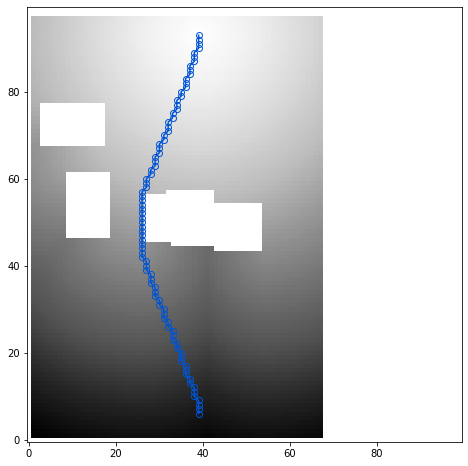

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.050226964056491824 vy:  0.3398667275905609 v:  0.3435580597824022
vx:  -0.30689963698387146 vy:  0.6754506826400757 v:  0.7419036405489438
vx:  -0.19374771416187292 vy:  0.7922333478927611 v:  0.8155806853134295
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.1452406

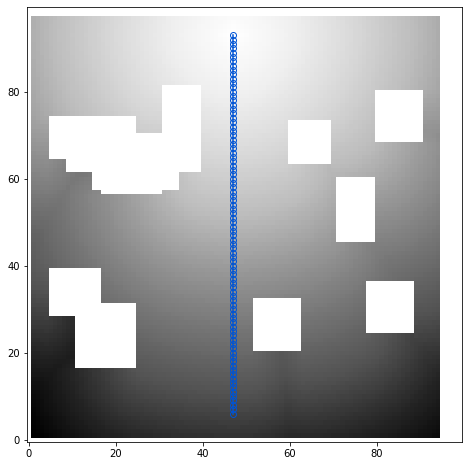

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.09334639459848412 vy:  0.4954030215740203 v:  0.5041207228127059
vx:  -0.026392154395580125 vy:  0.7842711210250853 v:  0.7847150674528839
vx:  0.1022001653909679 vy:  0.8983246088027954 v:  0.9041194481851591
vx:  0.10508099198341367 vy:  1.0337342023849487 v:  1.0390613148686965
vx:  0.14371936023235327 vy:  1.0467000007629395 v:  1.0565207740989926
vx:  0.15168486535549194 vy:  1.0518754720687862 v:  1.0627559960394697
vx:  0.14402538537979118 vy:  1.0531686544418335 v:  1.0629710844292142
vx:  0.12970510125160273 vy:  1.0488871335983276 v:  1.056876356211456
vx:  0.11105231940746299 vy:  1.0462684631347654 v:  1.052145576712729
vx:  0.09100548177957499 vy:  1.0431833267211914 v:  1.0471453819136216
vx:  0.0706860348582265 vy:  1.0399202108383176 v:  1.042319797583251
vx:  0.050667341798543875 vy:  1.0366361141204834 v:  1.0378736014678023
vx:  0.03288763761520397 vy:  1.0279163122177124 v:  1.0284422889161893
vx:  0.014420161955058075 vy:  1

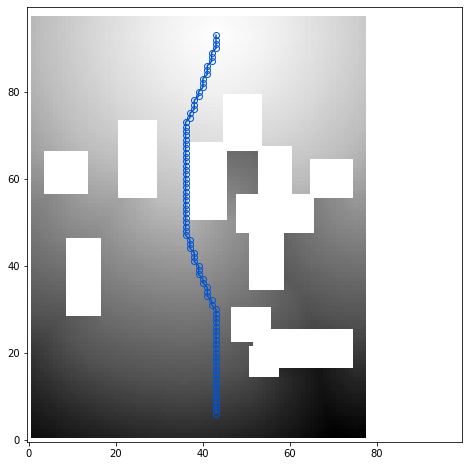

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.038853213191032354 vy:  0.70655357837677 v:  0.7076210364964332
vx:  -0.03422081470489508 vy:  0.9050435423851013 v:  0.9056902769556707
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.000138740419060885 vy:  0.9999999999999999 v:  1.0000000096244517
vx:  -0.000138740419060885 vy:  0.9999999999999999 v:  1.00000000962

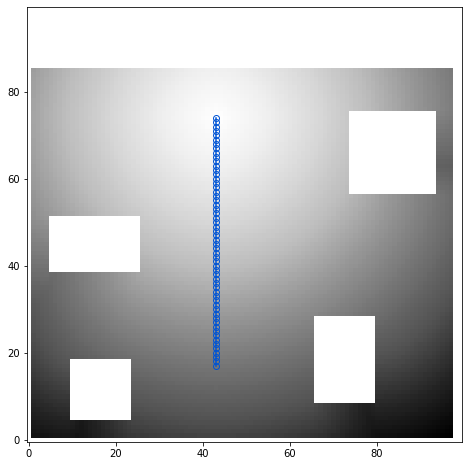

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.06613256782293322 vy:  0.36161503195762634 v:  0.36761249688302217
vx:  -0.021179385483264895 vy:  0.42165473103523254 v:  0.4221863078948002
vx:  0.020654749125242254 vy:  0.45712035894393926 v:  0.4575867581371456
vx:  0.09030544012784959 vy:  0.5177316665649414 v:  0.5255484288634077
vx:  0.0790164843201638 vy:  0.5058044791221619 v:  0.5119392306654768
vx:  0.07867041230201724 vy:  0.49270406365394587 v:  0.4989452155426294
vx:  0.04324236884713173 vy:  0.4828415215015412 v:  0.4847740064704735
vx:  -0.031170740723609924 vy:  0.4705875515937805 v:  0.47161876424956584
vx:  -0.13716143369674688 vy:  0.4826841950416565 v:  0.5017940723411936
vx:  -0.21747142076492312 vy:  0.5399322509765625 v:  0.5820830305842388
vx:  -0.23575313389301303 vy:  0.5763703584671022 v:  0.6227217117299451
vx:  -0.24594458937644964 vy:  0.5917198657989502 v:  0.6407972695203047
vx:  -0.18684248626232147 vy:  0.6240262389183043 v:  0.6513976216806525
vx:  -0.18636

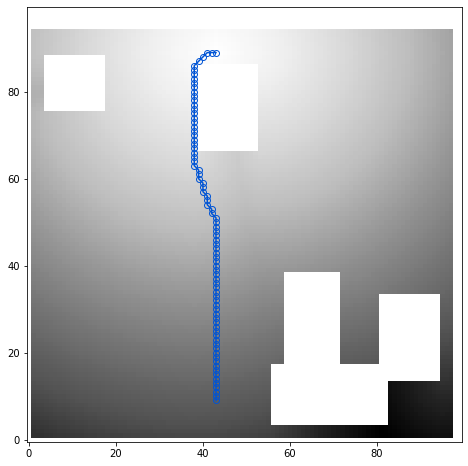

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1165772676467896 vy:  0.29864227771759033 v:  0.3205892533637732
vx:  -0.20910945534706116 vy:  0.7205705642700195 v:  0.750299075307946
vx:  -0.1769313514232636 vy:  0.8306470513343811 v:  0.8492815946474788
vx:  -0.1818825900554657 vy:  0.8990017771720886 v:  0.9172161533269343
vx:  -0.15311293303966522 vy:  0.9885991215705873 v:  1.000385822287654
vx:  -0.12750999629497534 vy:  1.0282864570617676 v:  1.036162070784193
vx:  -0.11796376109123236 vy:  1.0389254093170166 v:  1.045601001843112
vx:  -0.11495281010866187 vy:  1.0392627716064453 v:  1.0456009071337824
vx:  -0.11337029933929432 vy:  1.0394366979599 v:  1.045601010824904
vx:  -0.1125360131263734 vy:  1.039527416229248 v:  1.0456010727531966
vx:  -0.11209472268819792 vy:  1.0395749807357786 v:  1.0456009599394687
vx:  -0.11186049133539211 vy:  1.0396003723144531 v:  1.0456011207138909
vx:  -0.1117356866598131 vy:  1.0396137237548828 v:  1.0456010512106584
vx:  -0.11166893690824503 vy: 

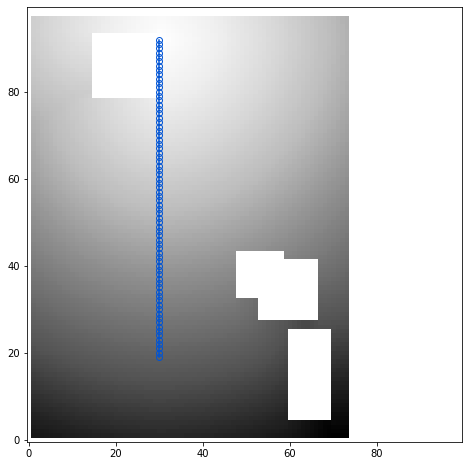

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.18487870693206793 vy:  0.5205380320549012 v:  0.5523947674376205
vx:  0.22011098265647883 vy:  0.6097679138183594 v:  0.6482790706234429
vx:  0.04382152855396268 vy:  0.6226049661636354 v:  0.6241452317020673
vx:  -0.15126919746398937 vy:  0.867290198802948 v:  0.8803832455476742
vx:  -0.1217937245965004 vy:  0.9333917498588562 v:  0.9413043450742515
vx:  -0.09284407645463938 vy:  0.9477590918540955 v:  0.9522958147155823
vx:  -0.0762545764446258 vy:  0.9533603787422179 v:  0.9564051297354351
vx:  -0.067470133304596 vy:  0.9563371539115906 v:  0.9587142279323183
vx:  -0.062199752777814865 vy:  0.9569991230964661 v:  0.9590183162239532
vx:  -0.05872145295143144 vy:  0.9563303589820862 v:  0.958131496480276
vx:  -0.05610982328653347 vy:  0.954823613166809 v:  0.9564708278510987
vx:  -0.05385514348745357 vy:  0.9527084827423097 v:  0.9542294428329111
vx:  -0.053913276642561014 vy:  0.9535320401191711 v:  0.9550549685395945
vx:  -0.05237237364053737

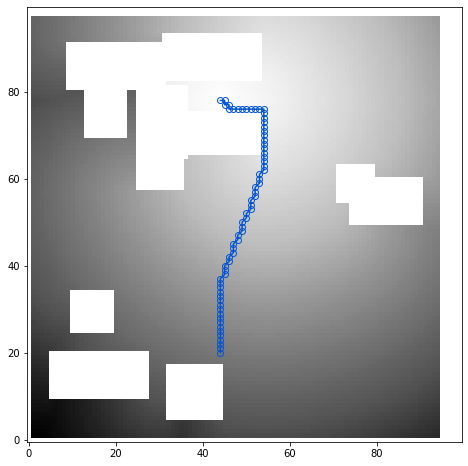

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.11140406131744385 vy:  0.24430218338966372 v:  0.2685040440793726
vx:  -0.18506433069705958 vy:  0.5597922801971437 v:  0.5895898603814926
vx:  -0.22223699092864982 vy:  0.6828442811965942 v:  0.718098595249924
vx:  -0.25075796246528614 vy:  0.7174835801124574 v:  0.7600409485486495
vx:  -0.2828570306301117 vy:  0.6768173575401307 v:  0.7335460689312493
vx:  -0.30514052510261547 vy:  0.6368134021759033 v:  0.7061459121532523
vx:  -0.3214990198612213 vy:  0.5997146368026733 v:  0.6804551898303726
vx:  -0.4163610041141509 vy:  0.6608952283859253 v:  0.7811139408884137
vx:  -0.2854909598827361 vy:  0.9141603708267212 v:  0.9577026008969666
vx:  -0.2514006793498993 vy:  0.9241168498992919 v:  0.9577025915415397
vx:  -0.2327472418546676 vy:  0.9289903044700623 v:  0.9577025970468777
vx:  -0.23016768693923953 vy:  0.905468463897705 v:  0.9342645788127842
vx:  -0.23559105396270758 vy:  0.869249701499939 v:  0.9006098979386093
vx:  -0.2429185658693314

In [3]:
from navrep.envs.e2eenv import E2E1DNavRepEnv
env = E2E1DNavRepEnv(silent=True, scenario='test', adaptive=False, collect_statistics=False)
#env.soadrl_sim.human_num = 7
#env.soadrl_sim.num_walls = 7
#env.soadrl_sim.num_circles = 7

data_reg = play_policy(env,1)

In [6]:
env.soadrl_sim.obstacle_vertices

[[(-1.9222712039705174, -5.322271203970518),
  (-4.077728796029483, -5.322271203970518),
  (-4.077728796029483, -7.477728796029483),
  (-1.9222712039705174, -7.477728796029483)],
 [(0.22671789043425028, 1.6267178904342505),
  (-0.8267178904342504, 1.6267178904342505),
  (-0.8267178904342504, 0.5732821095657498),
  (0.22671789043425028, 0.5732821095657498)],
 [(-1.2027019397565895, 2.697298060243411),
  (-3.197298060243411, 2.697298060243411),
  (-3.197298060243411, 0.7027019397565895),
  (-1.2027019397565895, 0.7027019397565895)],
 [(-1.013347616947582, -2.9133476169475823),
  (-1.986652383052418, -2.9133476169475823),
  (-1.986652383052418, -3.8866523830524184),
  (-1.013347616947582, -3.8866523830524184)],
 [(6.092999461024714, 1.0929994610247142),
  (4.7070005389752865, 1.0929994610247142),
  (4.7070005389752865, -0.2929994610247141),
  (6.092999461024714, -0.2929994610247141)],
 [(-1.280539896681852, 7.919460103318148),
  (-3.719460103318148, 7.919460103318148),
  (-3.7194601033181

[[22 10]]


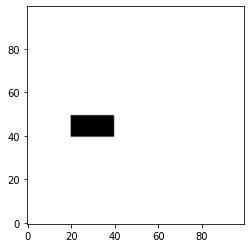

In [4]:
from map2d import gridshow

cmap2d = CMap2D.CMap2D()
cmap2d.set_resolution(0.1)
cmap2d.origin[0] = 0
cmap2d.origin[1] = 0
cmap2d._occupancy[20:40, 40:50] = 1.
coarse = cmap2d.as_coarse_map2d().as_coarse_map2d().as_coarse_map2d()

print(cmap2d.xy_to_ij([[2.26, 1.]]))

# occupancy
plt.figure("occupancy") 
grid = cmap2d.occupancy()
gridshow(grid)
plt.show()

In [5]:
env.reset()
i = 0
for vertex in env.soadrl_sim.obstacle_vertices:
    print(vertex)
    i+=1    
print(i)
env.render()

[(-1.9222712039705174, -5.322271203970518), (-4.077728796029483, -5.322271203970518), (-4.077728796029483, -7.477728796029483), (-1.9222712039705174, -7.477728796029483)]
[(0.22671789043425028, 1.6267178904342505), (-0.8267178904342504, 1.6267178904342505), (-0.8267178904342504, 0.5732821095657498), (0.22671789043425028, 0.5732821095657498)]
[(-1.2027019397565895, 2.697298060243411), (-3.197298060243411, 2.697298060243411), (-3.197298060243411, 0.7027019397565895), (-1.2027019397565895, 0.7027019397565895)]
[(-1.013347616947582, -2.9133476169475823), (-1.986652383052418, -2.9133476169475823), (-1.986652383052418, -3.8866523830524184), (-1.013347616947582, -3.8866523830524184)]
[(6.092999461024714, 1.0929994610247142), (4.7070005389752865, 1.0929994610247142), (4.7070005389752865, -0.2929994610247141), (6.092999461024714, -0.2929994610247141)]
[(-1.280539896681852, 7.919460103318148), (-3.719460103318148, 7.919460103318148), (-3.719460103318148, 5.480539896681853), (-1.280539896681852, 

ArgumentError: argument 2: <class 'TypeError'>: wrong type

In [ ]:
i

In [ ]:
import numpy as np
np.array((1,2))

In [ ]:
amap = CMap2D.CMap2D()
print(dir(env.soadrl_sim.robot))

In [ ]:
data = data_reg
print(data['rewards'][data['rewards']>2].size)
print(data['dones'][data['dones']==True].size)

In [ ]:
#177

#182

# 283 augmented

# 232 not augmented